# Notebook for the analysis of XPS data 

Analysis of `dati/Al_Ag_50V_fermilevel.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


/Users/a129544/anaconda3/envs/XPS/lib/python3.8/site-packages/arpes/config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2023-06-29_15-44-55.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
def load_csv_datatype(path_to_file: str, 
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """

    df = pd.read_csv(path_to_file, skiprows=1, sep='\t')

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [3]:
data_path = 'dati/Al_Ag_50V_fermilevel.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1,Scan2,Scan3,Scan4,Scan5,Scan6,Scan7
0,1500.0,1495.53,6228,864,887,885,938,880,933,841
1,1499.7,1495.26,6021,849,840,834,910,843,872,873
2,1499.4,1494.93,6001,884,876,851,873,873,753,891
3,1499.1,1494.68,6209,910,929,837,869,886,872,906
4,1498.8,1494.35,6171,921,839,884,903,883,883,858
...,...,...,...,...,...,...,...,...,...,...
163,1451.2,1447.33,5871,866,818,829,839,884,803,832
164,1450.9,1446.98,6141,860,866,935,848,876,891,865
165,1450.6,1446.77,6130,876,875,920,871,916,837,835
166,1450.3,1446.49,6187,934,834,959,907,857,832,864


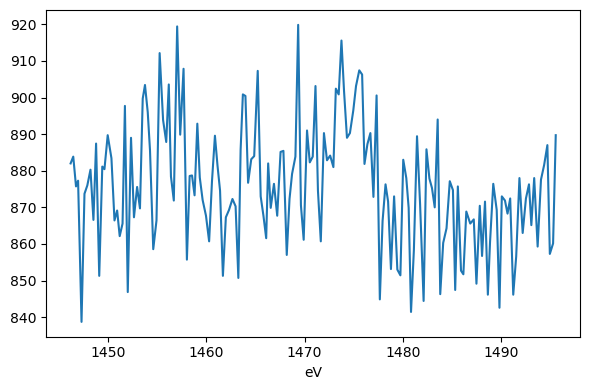

In [4]:
data = load_csv_datatype(path_to_file=data_path, n_scans=7)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_1632/2819893873.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(1473, 1480, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_center,1477.617,1473.000,1480.000,0.504,True,,
a_scale,60.181,-inf,inf,7.476,True,,
a_width,1.213,0.000,inf,0.458,True,,


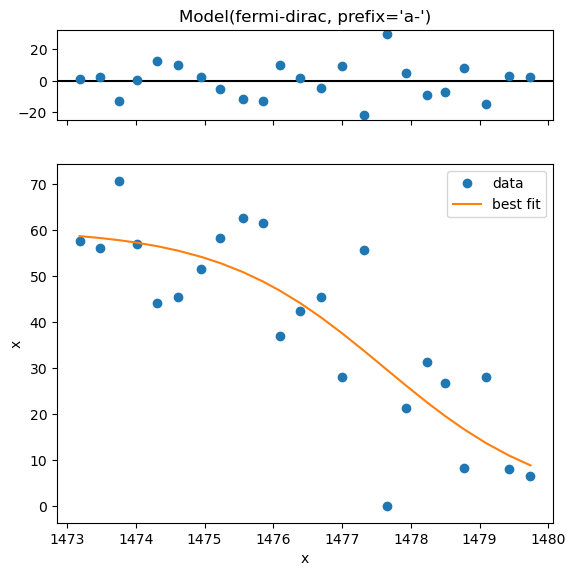

In [5]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel, FermiDiracModel, FermiLorentzianModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['Energy(meas)'].between(1473, 1480, inclusive=False).to_numpy()

test_curve = data.sel(eV=selection)
#test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model =  FermiDiracModel(prefix="a_") 
result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": 1477, "max":1480, "min":1473 },
        #"a_amplitude": {"min": 0},
        #"b_center": {"value": 910, "max":915, "min":907},
        #"b_amplitude": {"min": 0},
    }
)
result.plot()
result

In [6]:
print(result.fit_report())

[[Model]]
    Model(fermi_dirac, prefix='a_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 23
    # variables        = 3
    chi-square         = 2777.77031
    reduced chi-square = 138.888516
    Akaike info crit   = 116.259921
    Bayesian info crit = 119.666404
    R-squared          = 0.69735992
[[Variables]]
    a_center:  1477.61674 +/- 0.50422479 (0.03%) (init = 1477)
    a_width:   1.21338682 +/- 0.45800276 (37.75%) (init = 0.05)
    a_scale:   60.1805601 +/- 7.47577042 (12.42%) (init = 39.30435)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_center, a_scale) = -0.8049
    C(a_width, a_scale)  = +0.7606
    C(a_center, a_width) = -0.5649


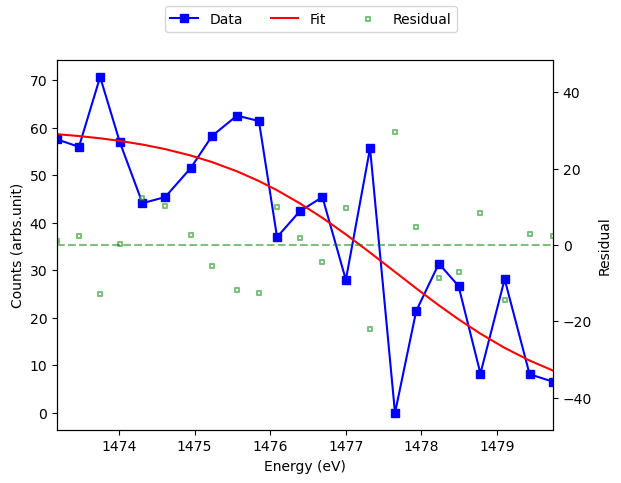

In [7]:
def plot_fit(model_result, ax=None):
    """Performs a straightforward plot of the data, residual, and fit to an axis."""
    if ax is None:
        fig, ax = plt.subplots()

    x = model_result.userkws[model_result.model.independent_vars[0]]
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.axhline(0, color="green", linestyle="--", alpha=0.5)

    ax.plot(x, model_result.data, color="blue", marker="s", linewidth=1.5, label='Data')
    ax.plot(x, model_result.best_fit, color="red", linewidth=1.5, label='Fit')

    ax2.scatter(
        x,
        model_result.residual,
        edgecolors="green",
        alpha=0.5,
        s=12,
        marker="s",
        c="white",
        linewidth=1.5,
        label='Residual'
    )
    ylim = np.max(np.abs(np.asarray(ax2.get_ylim()))) * 1.5
    ax2.set_ylim([-ylim, ylim])
    ax.set_xlim([np.min(x), np.max(x)])
    ax2.set_ylabel('Residual')
    ax.set_ylabel('Counts (arbs.unit)')
    ax.set_xlabel('Energy (eV)')
    




fig, ax = plt.subplots(1,1)
plot_fit(result, ax=ax)

fig.legend(loc='upper center', ncol=3)